# 任务
---
预测贷款用户是否会逾期。表格中 "status" 是结果标签：0表示未逾期，1表示逾期。

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score

## 1、导入数据

In [2]:
# 因为数据并非utf-8编码，要使用gbk编码读入，否则出错
data = pd.read_csv("./data.csv",encoding = "GBK")
print(data.shape)
data.head()
#df = data.copy()

(4754, 90)


,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [3]:
# 划分 X, y
y = data['status']
X = data.drop('status', axis=1)

# X行数
print('X.shape:', X.shape)
print('y 的分布:\n', y.value_counts())

X.shape: (4754, 89)
y 的分布:
 0    3561
1    1193
Name: status, dtype: int64


## 2、数据探索及预处理

In [4]:
X.info() # 缺失值情况，数据类型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 89 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

可以看出，该数据集有82个数值型特征(70个float型，12个int型)以及7个非数值型数据。其中`student_feature`特征有大量缺失值

In [5]:
X.student_feature.value_counts()

1.0    1754
2.0       2
Name: student_feature, dtype: int64

In [6]:
print(X.custid.value_counts().head())
print(X.custid.value_counts().tail())
X.custid.unique().shape

284669     1
1077931    1
309934     1
1045167    1
139340     1
Name: custid, dtype: int64
2927975    1
628072     1
3417450    1
814443     1
1009665    1
Name: custid, dtype: int64


(4754,)

In [7]:
print(X.trade_no.value_counts().head())
print(X.trade_no.value_counts().tail())
X.trade_no.unique().shape

20180504175930671000000381775659    1
20180507120520028000000388246721    1
20180504171156863000000381588328    1
20180504160719293000000021151418    1
20180507124438078000000388400560    1
Name: trade_no, dtype: int64
20180507113029991000000388128583    1
20180504175237066000000021271213    1
20180507122139445000000388307530    1
20180504173719479000000381685980    1
20180507123220801000000023092184    1
Name: trade_no, dtype: int64


(4754,)

In [8]:
print(X.bank_card_no.value_counts().head())
print(X.bank_card_no.value_counts().tail())
X.bank_card_no.unique().shape

卡号1    4754
Name: bank_card_no, dtype: int64
卡号1    4754
Name: bank_card_no, dtype: int64


(1,)

In [9]:
print(X.id_name.value_counts().head())
print(X.id_name.value_counts().tail())
X.id_name.unique().shape

李杰    5
李明    5
张龙    5
刘强    4
陈鹏    4
Name: id_name, dtype: int64
李雪峰    1
倪惠卫    1
纪玉烽    1
王守德    1
任启庆    1
Name: id_name, dtype: int64


(4310,)

 `student_feature` 缺失数据太多，将 `student_feature` 删除  
另外 `Unnamed: 0`、`custid`、`trade_no`、`bank_card_no`、`id_name`代表类似身份信息的变量在训练中不会使用，删除

In [10]:
del_cols = ['Unnamed: 0','custid', 'trade_no', 'bank_card_no','id_name', 'student_feature']
X.drop(del_cols, axis=1, inplace=True)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 83 columns):
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility                             4752 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4752 non-null float64
first_transacti

### 将数据区分为数值型和非数值型分别进行处理
#### 数值型变量

In [12]:
# 选取数值型特征
X_num = X.select_dtypes(include=['number']).copy()
print(X_num.shape)
# 查看缺失情况
num_miss_rate = 1 - X_num.count() / len(X_num)
num_miss_rate.sort_values(ascending=False)[:10]

(4754, 79)


cross_consume_count_last_1_month    0.089609
latest_three_month_apply            0.063946
query_finance_count                 0.063946
latest_six_month_apply              0.063946
query_sum_count                     0.063946
query_cash_count                    0.063946
latest_one_month_apply              0.063946
query_org_count                     0.063946
apply_credibility                   0.063946
apply_score                         0.063946
dtype: float64

In [14]:
# 数值型变量使用均值代替
X_num.fillna(X_num.mean(), inplace=True)

单变量分析：绘制直方图

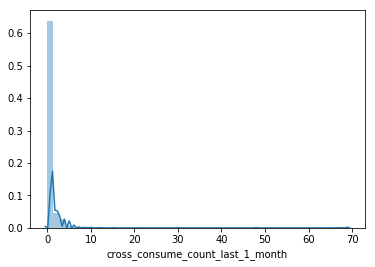

In [15]:
salary=X_num['cross_consume_count_last_1_month']
sns.distplot(salary)

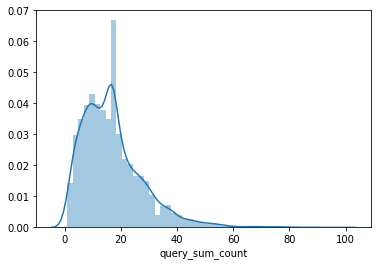

In [16]:
salary=X_num['query_sum_count']
sns.distplot(salary)

#### 非数值型变量（字符型变量）

In [17]:
# 查看其它非数值型变量的分类情况
for col in X.select_dtypes(include=['object']).columns:
    print ("Column {} has {} unique instances".format( col, len(X[col].unique())) )

Column reg_preference_for_trad has 6 unique instances
Column source has 1 unique instances
Column latest_query_time has 208 unique instances
Column loans_latest_time has 233 unique instances


In [18]:
# 处理对象类型字段的缺失程度，unique
X.select_dtypes(include=['O']).describe().T.\
assign(missing_pct=X.apply(lambda x : (len(x)-x.count())/float(len(x))))

,count,unique,top,freq,missing_pct
reg_preference_for_trad,4752,5,一线城市,3403,0.000421
source,4754,1,xs,4754,0.000000
latest_query_time,4450,207,2018-04-14,423,0.063946
loans_latest_time,4457,232,2018-05-03,134,0.062474


`latest_query_time` 和 `loans_latest_time` 属于日期格式，因不知具体业务逻辑，故直接删除。  
`source`只有一个结果没有意义，最后只剩 `reg_preference_for_trad` ，对其进行 缺失值填充（众数） 后，直接转换成哑变量

In [19]:
X.reg_preference_for_trad.value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [20]:
X_str = X.select_dtypes(exclude='number').copy()
X_str.describe().T

,count,unique,top,freq
reg_preference_for_trad,4752,5,一线城市,3403
source,4754,1,xs,4754
latest_query_time,4450,207,2018-04-14,423
loans_latest_time,4457,232,2018-05-03,134


In [21]:
X_str['reg_preference_for_trad'] = X_str['reg_preference_for_trad'].fillna(X_str['reg_preference_for_trad'].mode()[0])
X_str_dummy = pd.get_dummies(X_str['reg_preference_for_trad'])
X_str_dummy.head()

,一线城市,三线城市,二线城市,其他城市,境外
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [31]:
# 拼接
X_con = pd.concat([X_num, X_str_dummy], axis=1, sort=False)
X_con.shape

(4754, 84)

## 3、划分数据

In [32]:
# 随机数
random_state = 2018

X_train,X_test, y_train, y_test = train_test_split(X_con , y ,test_size=0.3, random_state = random_state)

数据标准化

In [36]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

print(X_train.shape)
print(X_test.shape)

(3327, 84)
(1427, 84)


In [42]:
# 好坏的比例
print(y_train.value_counts())
print(y_test.value_counts())

0    2493
1     834
Name: status, dtype: int64
0    1068
1     359
Name: status, dtype: int64


## 4、建模

In [44]:
# 先用网格搜索选下超参，
# 评价参数没有给出，这次使用 f1_micro 作为评价标准
lr = LogisticRegression(solver='liblinear')
param_grid = {
    'C': [0.05, 0.1, 0.5, 1, 5],
    'penalty': ['l1', 'l2']
}

grid = GridSearchCV(lr, param_grid=param_grid, scoring='f1_micro')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

C:\Users\paiy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 0.1, 'penalty': 'l1'}
0.7950105199879771


In [45]:
# 使用训练好的超参进行建模
lr = LogisticRegression(**grid.best_params_,solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## 5、评估

用测试集对模型效果进行评估，主要使用 准确性，ks，auc，f1 等指标

In [49]:
# 准确性
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('准确性：')
print('训练集：{:.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('测试集：{:.4f}'.format(accuracy_score(y_test, y_test_pred)))

准确性：
训练集：0.8010
测试集：0.7835


In [50]:
# f1_score
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print('f1_score：')
print('训练集：{:.4f}'.format(f1_score(y_train, y_train_pred)))
print('测试集：{:.4f}'.format(f1_score(y_test, y_test_pred)))

f1_score：
训练集：0.4618
测试集：0.4181


ROC AUC：
训练集：0.8135
测试集：0.7780
KS：
训练集：0.4907
测试集：0.4142


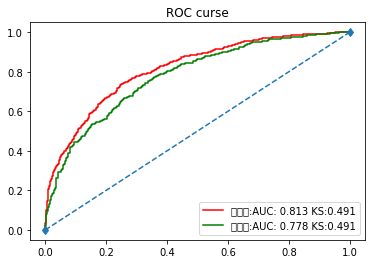

In [51]:
# roc_auc, ks
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_proba)
fpr_te, tpr_te, _ = roc_curve(y_test, y_test_proba)

print('ROC AUC：')
print('训练集：{:.4f}'.format(roc_auc_score(y_train, y_train_proba)))
print('测试集：{:.4f}'.format(roc_auc_score(y_test, y_test_proba)))

print('KS：')
print('训练集：{:.4f}'.format(max(abs((fpr_tr - tpr_tr)))))
print('测试集：{:.4f}'.format(max(abs((fpr_te - tpr_te)))))

# 绘图
plt.plot(fpr_tr, tpr_tr, 'r-',
         label="训练集:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_train, y_train_proba), max(abs((fpr_tr - tpr_tr)))))
plt.plot(fpr_te, tpr_te, 'g-',
         label="测试集:AUC: {:.3f} KS:{:.3f}".format(roc_auc_score(y_test, y_test_proba),
                                                 max(abs((fpr_tr - tpr_tr)))))
plt.plot([0, 1], [0, 1], 'd--')
plt.legend(loc='best')
plt.title("ROC curse")
plt.show()